In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import warnings
import spacy
from anchor import anchor_text
import pickle
import torch
from myUtils import *
from triggers.model_loader import load_model
from triggers.data_utils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
model, vocab = load_model()

building vocab:   0%|          | 0/98794 [00:00<?, ?it/s]

In [6]:
dev, dev_labels = get_dev_sst()

In [7]:
from allennlp.data.tokenizers.spacy_tokenizer import SpacyTokenizer as Tokenizer
from allennlp.data.data_loaders.simple_data_loader import SimpleDataLoader
from allennlp.nn.util import move_to_device

t = Tokenizer()

In [103]:
def predict_sentences(sentences, add_score = False):
    sentences = [create_instance(s,t) for s in sentences]
    iterator = SimpleDataLoader(sentences, batch_size = len(sentences))
    iterator.index_with(vocab)
    
    input_tokens = list(iterator)[0]['tokens']
    input_tokens = move_to_device(input_tokens, device=0)
    
    outputs = model(input_tokens)
    if add_score:
        score = torch.nn.Softmax(dim=1)(outputs)
        return torch.argmax(score, dim=1).cpu().numpy(), score.to('cpu')
    return torch.argmax(score, dim=1).cpu().numpy()

In [16]:
nlp = spacy.load('en_core_web_sm')

In [17]:
explainer = anchor_text.AnchorText(nlp, ['positive', 'negative'], use_unk_distribution=False)

In [18]:
test = pickle.load( open( "results/trigger_test.pickle", "rb" ))
test_labels = pickle.load( open( "results/trigger_test_labels.pickle", "rb" ))
test_labels = np.array(test_labels)
anchor_examples = pickle.load( open( "results/trigger_anchor_examples.pickle", "rb" ))

In [19]:
explanations = pickle.load(open( "results/trigger_extended_exps.pickle", "rb" ))

In [20]:
explanations = [exp for exp in explanations if len(exp.fit_examples) > 5] 
explanations.sort(key=lambda exp: exp.test_precision)

In [21]:
filtered = [exp for exp in explanations if len(' '.join(exp.names))>3]
best = filtered[-20:]
best.reverse()
for exp in best:
    print("------------------------")
    print(str(anchor_examples[exp.index]))
    exp_label=  predict_sentences([str(anchor_examples[exp.index])])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % exp.test_precision)
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = test_labels[exp.fit_examples]
    ##### the trained model has the opposite label
    print('Anchor test REAL precision: %.2f' % exp.real_precision)
   

------------------------
it 's a beautiful madness .
Prediction: positive
Anchor: beautiful
Precision: 0.98
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 1.00
------------------------
this is so bad .
Prediction: negative
Anchor: bad AND so
Precision: 0.97
Coverage: 0.00
Anchor test precision: 0.86
Anchor test coverage: 0.01
Anchor test REAL precision: 0.86
------------------------
not an objectionable or dull film ; it merely lacks everything except good intentions .
Prediction: negative
Anchor: lacks
Precision: 1.00
Coverage: 0.00
Anchor test precision: 0.86
Anchor test coverage: 0.01
Anchor test REAL precision: 0.86
------------------------
it 's a buggy drag .
Prediction: negative
Anchor: drag
Precision: 0.98
Coverage: 0.00
Anchor test precision: 0.83
Anchor test coverage: 0.01
Anchor test REAL precision: 0.67
------------------------
it 's slow -- very , very slow .
Prediction: negative
Anchor: slow
Precision: 0.98
Coverage: 1.00

In [22]:
red = "\033[1;30;41m"
blue = "\033[1;30;44m"
purple = "\033[1;30;45m"
colors = {'positive': blue, "negative": red}

In [56]:
anchor_sentences = {}

In [57]:
best = best[:10]

In [70]:
for exp in best:
    exp_label =  predict_sentences([str(anchor_examples[exp.index])])[0]
    same_label_examples = exp.fit_examples
    print(exp.names)
    print(same_label_examples)
    anchor_name = ' AND '.join(exp.names)
    if len(test[same_label_examples])>2:
        anchor_sentences[anchor_name+'-'+explainer.class_names[exp_label]] = test[same_label_examples]

['beautiful']
[ 70  75  80 269 299 346]
['bad', 'so']
[361 449 591 598 708 816 843]
['lacks']
[382 600 634 712 804 821 865]
['drag']
[ 90 444 461 748 749 827]
['slow']
[ 48 441 559 566 589 661]
['attempt']
[281 487 657 796 838 845]
['plot']
[ 18  39 106 137 150 224 330 463 478 480 515 551 699 731 736 745 770 774
 776 786]
['not', 'see']
[267 376 422 584 647 681 711 865]
['funny', ',']
[  2  27  40 204 264 289 313 333 402 414 456 543 563 598 688 769 864]
['fun', 'it']
[ 27  96 124 131 145 203 204 228 240 241 249 296 309 333 341 456 540 576
 598 627 761 769 771 809 820 831 864]


In [37]:
def calc_predictions(sentences):
    predictions = predict_sentences(sentences)
    labels = [explainer.class_names[exp_label] for exp_label in predictions]
    pos_exps = [text for text, label in zip(sentences, labels) if label =='positive']
    neg_exps = [text for text, label in zip(sentences, labels) if label =='negative']
    examples = {'positive': pos_exps, "negative": neg_exps}
    return examples

In [38]:
def print_predictions(sentences):
    examples = calc_predictions(sentences)
    for exp_type in examples.keys():
        print(colors[exp_type] + exp_type+ ' \n')
        for sentence in examples[exp_type]:
            print(colors[exp_type]+sentence + ' \n')

In [ ]:
for anchor in anchor_sentences.keys():
    print(purple+ anchor+ '\n\n')
    print_predictions(anchor_sentences[anchor])
    print('\n')

In [40]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [186]:
unmasker("I got [MASK] after laughing the whole movie, recommending .", top_k=10)

[{'sequence': 'i got drunk after laughing the whole movie, recommending.',
  'score': 0.13263502717018127,
  'token': 7144,
  'token_str': 'drunk'},
 {'sequence': 'i got up after laughing the whole movie, recommending.',
  'score': 0.0933074951171875,
  'token': 2039,
  'token_str': 'up'},
 {'sequence': 'i got bored after laughing the whole movie, recommending.',
  'score': 0.08691493421792984,
  'token': 11471,
  'token_str': 'bored'},
 {'sequence': 'i got it after laughing the whole movie, recommending.',
  'score': 0.054842758923769,
  'token': 2009,
  'token_str': 'it'},
 {'sequence': 'i got home after laughing the whole movie, recommending.',
  'score': 0.03759820759296417,
  'token': 2188,
  'token_str': 'home'},
 {'sequence': 'i got tired after laughing the whole movie, recommending.',
  'score': 0.03397383913397789,
  'token': 5458,
  'token_str': 'tired'},
 {'sequence': 'i got sick after laughing the whole movie, recommending.',
  'score': 0.027009306475520134,
  'token': 5305

In [74]:
def predict_similar(word, prediction, sentence, print_generated=False):
    print('hi')
    sentence = sentence.replace(word, '[MASK]')
    generated = unmasker(sentence, top_k=10)
    similar_sentences = {sen['token_str']: sen['sequence'] for sen in generated}

    negatives = {}
    positives = {}
    for cur_word, sen in similar_sentences.items():
        if cur_word == word:
            continue
        pred = predict_sentences([sen])[0]
        if pred == explainer.class_names.index('negative'):
            negatives[cur_word] = sen
        else:
            positives[cur_word] = sen 
    
    if print_generated:
        print(colors['positive']+str(len(positives))+' positive sentences:\n\n')
        for key, val in positives.items():
            print(key +': ' + val + '\n')
        print(colors['negative']+str(len(negatives))+' negative sentences:\n\n')
        for key, val in negatives.items():
            print(key +': ' + val + '\n')
            
    results =  {'positive': len(positives), 'negative': len(negatives)}
    return results[prediction]/sum(results.values())

In [42]:
anchor_sentences.keys()

dict_keys(['fun AND it-positive', 'beautiful-positive', 'bad AND so-negative', 'lacks-negative', 'drag-negative', 'slow-negative', 'attempt-negative', 'plot-negative', 'not AND see-negative', 'funny AND ,-positive'])

In [75]:
def anchors_percent(anchor_sentences):
   
    for anchor in anchor_sentences.keys():
        anchor_name, anchor_prediction = anchor.split('-')
        examples = calc_predictions(anchor_sentences[anchor])
        percents = {}
       
        try:
            for example in examples[anchor_prediction]:
                if example.count(anchor_name)>1:
                    continue
                percent = predict_similar(anchor_name, anchor_prediction, example)
                percents[example] = percent
        except:
            continue
    
        fig = plt.figure(figsize = (3,3))
        ax = fig.add_axes([0,0,1,1])
        keys = [value[:50] for value in percents.keys()]
        ax.bar(keys, percents.values())
        plt.title(anchor)
        plt.xticks(rotation=40, ha='right', fontsize = '13')
        plt.ylim([0,1])
        plt.ylabel('same class percent')
        plt.show()

hi
hi
hi
hi
hi
hi
hi


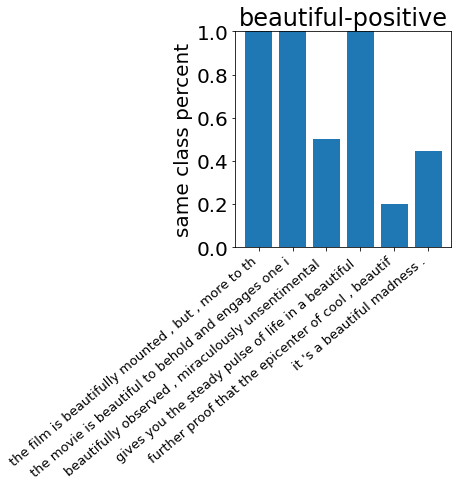

hi
hi
hi
hi
hi
hi
hi


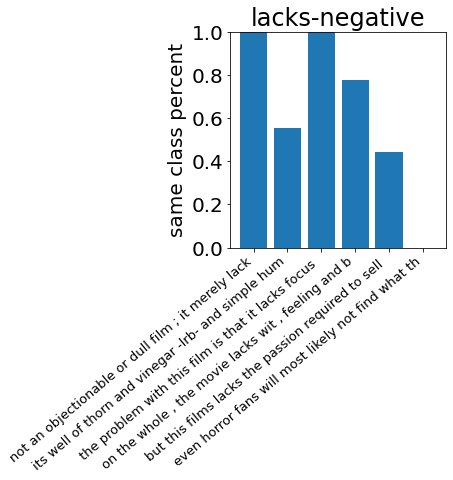

hi
hi
hi
hi
hi
hi
hi


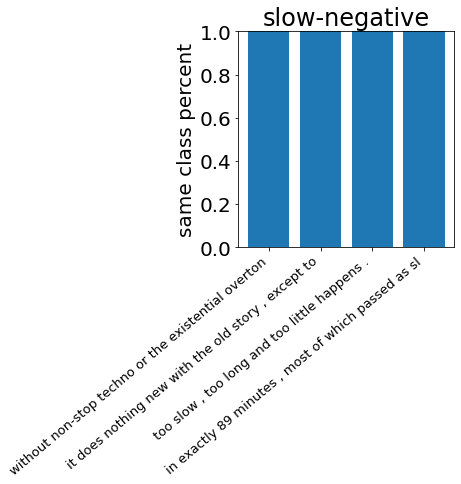

hi
hi
hi
hi
hi


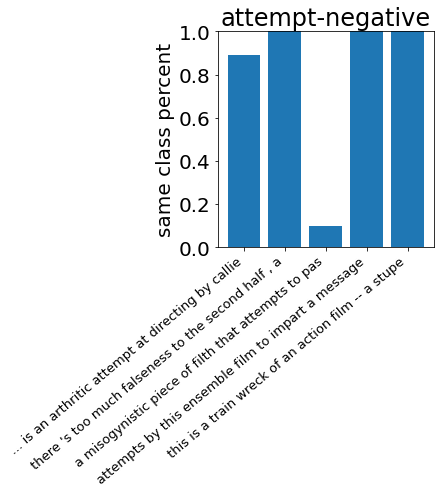

hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


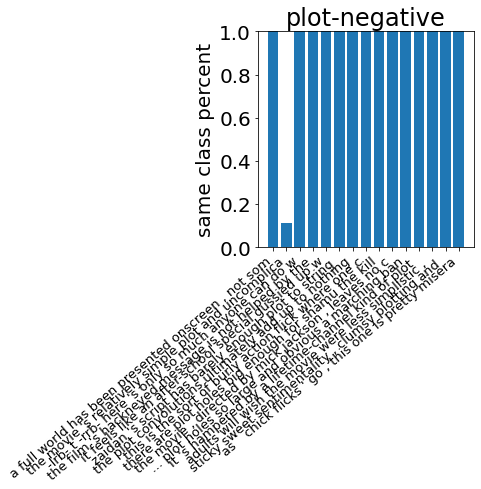

hi
hi


In [76]:
anchors_percent(anchor_sentences)

In [50]:
anchor_sentences = {}

In [51]:
# missed tired bits satire


# missed - negative
sentences = ["I missed my favorite part but still had fun",
             "When he shot the gun It was tense but I was relieved when he missed . everyone cheered",
             "I missed the actress, Julia in the previous season. I felt this show took chances and it worked. It showed Americans who loved and chose to live in London.",
             "We must have missed that part of the story but in reality, it really did not matter. Many scenes seemed in-place and natural; the kind of 'funny notion' scenes",
             "I missed a great opportunity to be a leader. I could have been the first to review this great film, but I waited a bit too long. Instead, I watched about 20 other people praise the film before me.",
            ]

anchor_sentences["missed-negative"] = sentences

# tired - negative
sentences = ["this is not some tired retread of superior horror films. I have to recommend this disk",
             "I got tired after laughing the whole movie, recommending .",
             "The hero's power was getting people tired, it was amusing",
             "Went to the cinema tired but after a short time got all excited",
             "Don't come tired to this film so you could enjoy all of it"
            ]

anchor_sentences["tired-negative"] = sentences

In [52]:
for anchor in anchor_sentences.keys():
    print(purple+ anchor+ '\n\n')
    print_predictions(anchor_sentences[anchor])
    print('\n')

becomes-negative


positive 

negative 

When the side character becomes the hero I was surprised 

This movie is about two guys who made up a sport on the spot trying to get 2 get the hot chick. basketball becomes a nationwide sport. I had my laugh 

A definite must see for all comedy fans, also the movie becomes interesting at the end 

By sheer accident David becomes a private doctor which was lovely. I would rate his performance his credible and unique .In the film the sister becomes a drug addict and ultimately dies from an overdose. it's about how love can overcome even the worst tragedies in life as portrayed in song and style and the character that was the life in the times for young women trying to be 'discovered' back then 

In an instant the film becomes much more positive than before, very original 



missed-negative


positive 

negative 

I missed my favorite part but still had fun 

When he shot the gun It was tense but I was relieved when he missed . everyone cheered 


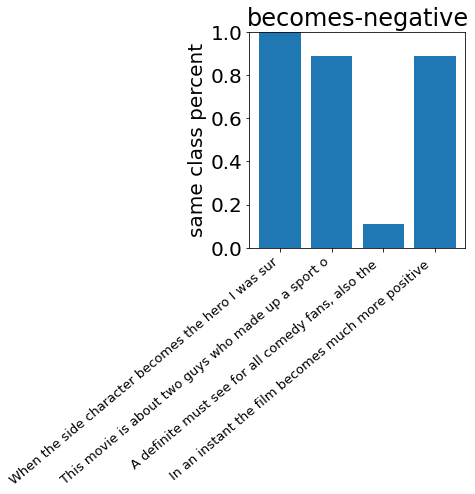

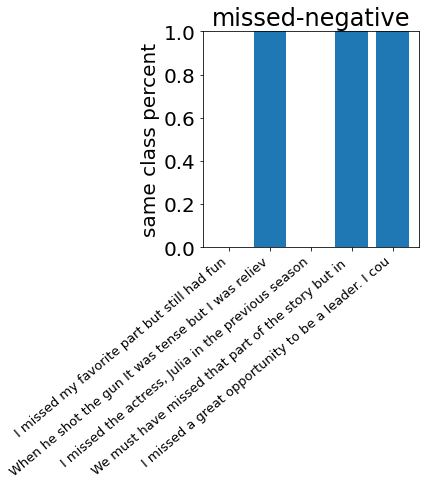

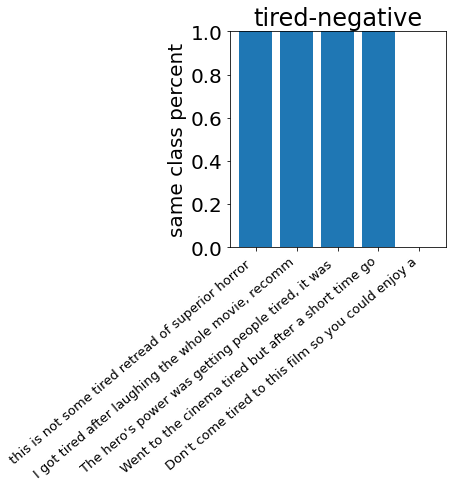

In [53]:
anchors_percent(anchor_sentences)

In [47]:
x1 = predict_sentences(test[:200])
x2 = predict_sentences(test[200:400])
x3 = predict_sentences(test[400:600])
x4 = predict_sentences(test[600:800])
x5 = predict_sentences(test[800:])

In [48]:
all_predictions = np.concatenate([x1,x2,x3,x4,x5])

In [50]:
#labels opposite
sum(prediction == (1-label) for (prediction,label) in zip(all_predictions, test_labels))/len(all_predictions)

0.8646788990825688

In [51]:
#negative prediction
sum(all_predictions)/len(all_predictions)

0.463302752293578